In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import zscore
import requests
import warnings
warnings.filterwarnings('ignore')
from math import sqrt

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

# Retrieve data from the Alpha Vantage API for the commodities of Coffee and Sugar

In [2]:
sugar_url = 'https://www.alphavantage.co/query?function=SUGAR&interval=monthly&apikey=demo'
coffee_url = 'https://www.alphavantage.co/query?function=COFFEE&interval=monthly&apikey=demo'


sugar_r = requests.get(sugar_url)
coffee_r = requests.get(coffee_url)

sugar_data = sugar_r.json()
coffee_data = coffee_r.json()

# Store the data in a Pandas DataFrame

In [3]:
sugar_data = pd.DataFrame(sugar_data)
sugar_data

,name,interval,unit,data
0,Global Price of Sugar,monthly,cents per pound,"{'date': '2023-03-01', 'value': '20.9617391304..."
1,Global Price of Sugar,monthly,cents per pound,"{'date': '2023-02-01', 'value': '21.4035'}"
2,Global Price of Sugar,monthly,cents per pound,"{'date': '2023-01-01', 'value': '19.9431818181..."
3,Global Price of Sugar,monthly,cents per pound,"{'date': '2022-12-01', 'value': '20.065'}"
4,Global Price of Sugar,monthly,cents per pound,"{'date': '2022-11-01', 'value': '19.4059090909..."
...,...,...,...,...
514,Global Price of Sugar,monthly,cents per pound,"{'date': '1980-05-01', 'value': '.'}"
515,Global Price of Sugar,monthly,cents per pound,"{'date': '1980-04-01', 'value': '.'}"
516,Global Price of Sugar,monthly,cents per pound,"{'date': '1980-03-01', 'value': '.'}"
517,Global Price of Sugar,monthly,cents per pound,"{'date': '1980-02-01', 'value': '.'}"


In [4]:
coffee_data = pd.DataFrame(coffee_data)
coffee_data

,name,interval,unit,data
0,Global Price of Coffee,monthly,cents per pound,"{'date': '2023-03-01', 'value': '222.663913043..."
1,Global Price of Coffee,monthly,cents per pound,"{'date': '2023-02-01', 'value': '229.506'}"
2,Global Price of Coffee,monthly,cents per pound,"{'date': '2023-01-01', 'value': '206.76'}"
3,Global Price of Coffee,monthly,cents per pound,"{'date': '2022-12-01', 'value': '210.388636363..."
4,Global Price of Coffee,monthly,cents per pound,"{'date': '2022-11-01', 'value': '213.718181818..."
...,...,...,...,...
514,Global Price of Coffee,monthly,cents per pound,"{'date': '1980-05-01', 'value': '.'}"
515,Global Price of Coffee,monthly,cents per pound,"{'date': '1980-04-01', 'value': '.'}"
516,Global Price of Coffee,monthly,cents per pound,"{'date': '1980-03-01', 'value': '.'}"
517,Global Price of Coffee,monthly,cents per pound,"{'date': '1980-02-01', 'value': '.'}"


In [5]:
sugar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      519 non-null    object
 1   interval  519 non-null    object
 2   unit      519 non-null    object
 3   data      519 non-null    object
dtypes: object(4)
memory usage: 16.3+ KB


# Create a data frame containing the dates and values

In [6]:
sugar_df = sugar_data['data'].apply(pd.Series)
sugar_df

,date,value
0,2023-03-01,20.9617391304348
1,2023-02-01,21.4035
2,2023-01-01,19.9431818181818
3,2022-12-01,20.065
4,2022-11-01,19.4059090909091
...,...,...
514,1980-05-01,.
515,1980-04-01,.
516,1980-03-01,.
517,1980-02-01,.


In [7]:
coffee_df = coffee_data['data'].apply(pd.Series)
coffee_df

,date,value
0,2023-03-01,222.663913043478
1,2023-02-01,229.506
2,2023-01-01,206.76
3,2022-12-01,210.388636363636
4,2022-11-01,213.718181818182
...,...,...
514,1980-05-01,.
515,1980-04-01,.
516,1980-03-01,.
517,1980-02-01,.


In [8]:
sugar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    519 non-null    object
 1   value   519 non-null    object
dtypes: object(2)
memory usage: 8.2+ KB


In [9]:
coffee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    519 non-null    object
 1   value   519 non-null    object
dtypes: object(2)
memory usage: 8.2+ KB


# Ensure that the columns are data types that can be analysed

In [10]:
# Convert the date to type datetime

sugar_df['date'] = pd.to_datetime(sugar_df['date'])
coffee_df['date'] = pd.to_datetime(coffee_df['date'])

In [11]:
# Replace '.' values with null values
sugar_df['value'] = sugar_df['value'].replace('.', np.nan)
coffee_df['value'] = coffee_df['value'].replace('.', np.nan)

In [12]:
# Convert the value to type float

sugar_df['value'] = sugar_df['value'].astype(float)
coffee_df['value'] = coffee_df['value'].astype(float)

In [13]:
# Rename the columns to more appropriate headings

sugar_df.rename(columns={"date":"Date","value": "Sugar Price"}, inplace=True)
coffee_df.rename(columns={"date":"Date","value": "Coffee Price"}, inplace=True)


In [14]:
sugar_df

,Date,Sugar Price
0,2023-03-01,20.961739
1,2023-02-01,21.403500
2,2023-01-01,19.943182
3,2022-12-01,20.065000
4,2022-11-01,19.405909
...,...,...
514,1980-05-01,NaN
515,1980-04-01,NaN
516,1980-03-01,NaN
517,1980-02-01,NaN


In [15]:
coffee_df

,Date,Coffee Price
0,2023-03-01,222.663913
1,2023-02-01,229.506000
2,2023-01-01,206.760000
3,2022-12-01,210.388636
4,2022-11-01,213.718182
...,...,...
514,1980-05-01,NaN
515,1980-04-01,NaN
516,1980-03-01,NaN
517,1980-02-01,NaN


In [16]:
sugar_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         519 non-null    datetime64[ns]
 1   Sugar Price  399 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.2 KB


In [17]:
coffee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519 entries, 0 to 518
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          519 non-null    datetime64[ns]
 1   Coffee Price  399 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 8.2 KB


#  Clean the data for analysis

In [18]:
# Remove null values

sugar_df = sugar_df.dropna()
coffee_df = coffee_df.dropna()

In [19]:
# Remove duplicate values

sugar_df.drop_duplicates()
coffee_df.drop_duplicates()

,Date,Coffee Price
0,2023-03-01,222.663913
1,2023-02-01,229.506000
2,2023-01-01,206.760000
3,2022-12-01,210.388636
4,2022-11-01,213.718182
...,...,...
394,1990-05-01,92.019989
395,1990-04-01,93.730011
396,1990-03-01,93.959991
397,1990-02-01,84.010010


In [20]:
#Include a difference column for analyis

sugar_df['Price Difference'] = sugar_df['Sugar Price'].diff()
coffee_df['Price Difference'] = coffee_df['Coffee Price'].diff()

sugar_df.fillna(0, inplace = True)
coffee_df.fillna(0, inplace = True)

In [21]:
sugar_df

,Date,Sugar Price,Price Difference
0,2023-03-01,20.961739,0.000000
1,2023-02-01,21.403500,0.441761
2,2023-01-01,19.943182,-1.460318
3,2022-12-01,20.065000,0.121818
4,2022-11-01,19.405909,-0.659091
...,...,...,...
394,1990-05-01,14.619999,1.649998
395,1990-04-01,15.240002,0.620003
396,1990-03-01,15.310001,0.070000
397,1990-02-01,14.650002,-0.660000


In [22]:
coffee_df

,Date,Coffee Price,Price Difference
0,2023-03-01,222.663913,0.000000
1,2023-02-01,229.506000,6.842087
2,2023-01-01,206.760000,-22.746000
3,2022-12-01,210.388636,3.628636
4,2022-11-01,213.718182,3.329545
...,...,...,...
394,1990-05-01,92.019989,3.759979
395,1990-04-01,93.730011,1.710022
396,1990-03-01,93.959991,0.229980
397,1990-02-01,84.010010,-9.949982


# Descriptive statistics to understand the data's central tendency and spread

In [23]:
sugar_df.describe()

,Sugar Price,Price Difference
count,399.000000,399.000000
mean,13.137825,-0.016947
std,5.125401,1.038431
min,5.111200,-4.546455
25%,9.352386,-0.535184
50%,12.061905,-0.013238
75%,16.509969,0.551441
max,29.736842,3.831121


In [24]:
coffee_df.describe()

,Coffee Price,Price Difference
count,399.000000,399.000000
mean,136.677453,-0.368005
std,55.900913,10.746359
min,50.830000,-68.048636
25%,91.454775,-5.112448
50%,129.723500,0.599567
75%,165.888886,4.697128
max,300.477143,38.844957


# Distribution plots to help identify skewness, outliers, and other patterns.

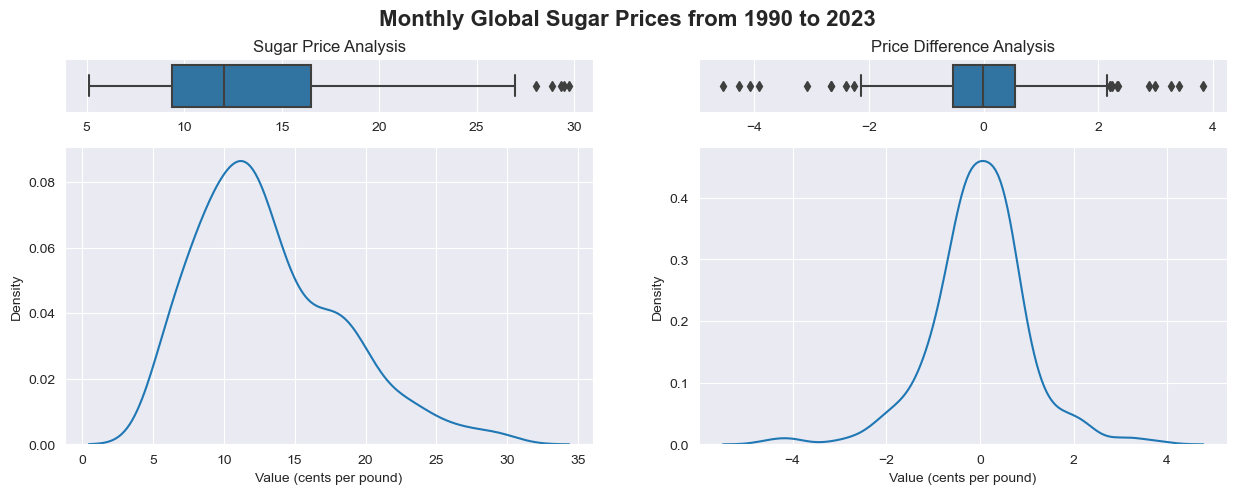

In [25]:
sns.set_style('darkgrid')

fig, ax  = plt.subplots(nrows = 2, 
                        ncols = 2, 
                        gridspec_kw = {"height_ratios": (.15, .85)},
                        figsize=(15,5))

sns.boxplot(data = sugar_df,
            x = sugar_df["Sugar Price"], 
            ax = ax[0,0], 
            orient = "h")
sns.kdeplot(data = sugar_df,
            x = sugar_df["Sugar Price"], 
            ax = ax[1,0])

sns.boxplot(data = sugar_df,
            x = sugar_df["Price Difference"],
            ax = ax[0,1], orient = "h")
sns.kdeplot(data = sugar_df,
            x = sugar_df["Price Difference"],
            ax = ax[1,1])


ax[0,0].set(xlabel = '', title = 'Sugar Price Analysis')
ax[0,1].set(xlabel = '', title = 'Price Difference Analysis')
ax[1,0].set(xlabel = 'Value (cents per pound)', ylabel = 'Density')
ax[1,1].set(xlabel = 'Value (cents per pound)', ylabel = 'Density')

fig.suptitle("Monthly Global Sugar Prices from 1990 to 2023",
             fontsize = 16, 
             fontweight = 'bold');


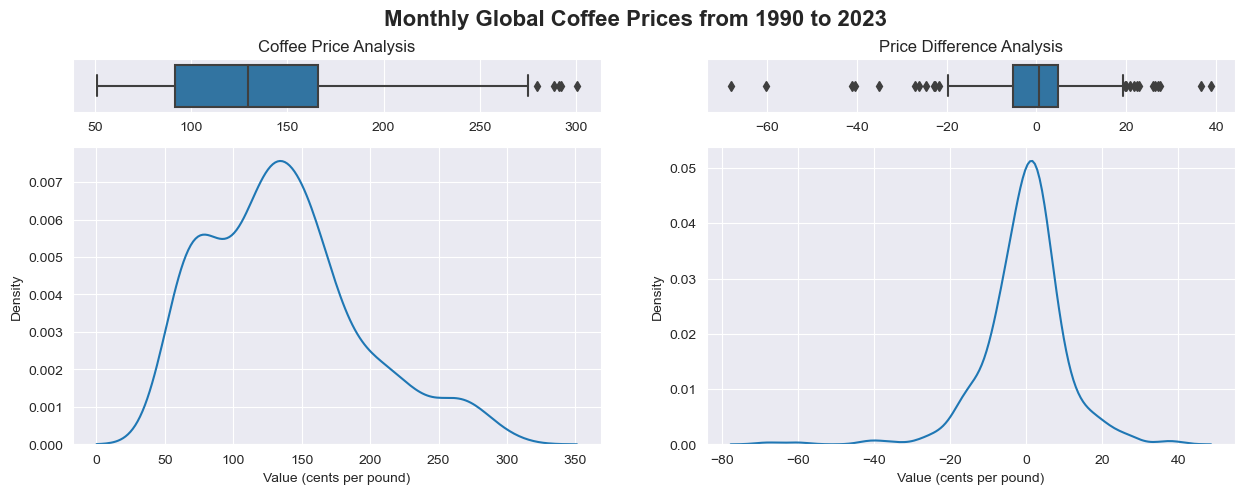

In [26]:
sns.set_style('darkgrid')

fig, ax  = plt.subplots(nrows = 2, 
                        ncols = 2, 
                        gridspec_kw = {"height_ratios": (.15, .85)},
                        figsize=(15,5))

sns.boxplot(data = coffee_df,
            x = coffee_df["Coffee Price"], 
            ax = ax[0,0], 
            orient = "h")
sns.kdeplot(data = coffee_df,
            x = coffee_df["Coffee Price"], 
            ax = ax[1,0])

sns.boxplot(data = coffee_df,
            x = coffee_df["Price Difference"],
            ax = ax[0,1], orient = "h")
sns.kdeplot(data = coffee_df,
            x = coffee_df["Price Difference"],
            ax = ax[1,1])


ax[0,0].set(xlabel = '', title = 'Coffee Price Analysis')
ax[0,1].set(xlabel = '', title = 'Price Difference Analysis')
ax[1,0].set(xlabel = 'Value (cents per pound)', ylabel = 'Density')
ax[1,1].set(xlabel = 'Value (cents per pound)', ylabel = 'Density')

fig.suptitle("Monthly Global Coffee Prices from 1990 to 2023",
             fontsize = 16, 
             fontweight = 'bold');


# Time-Series Analysis

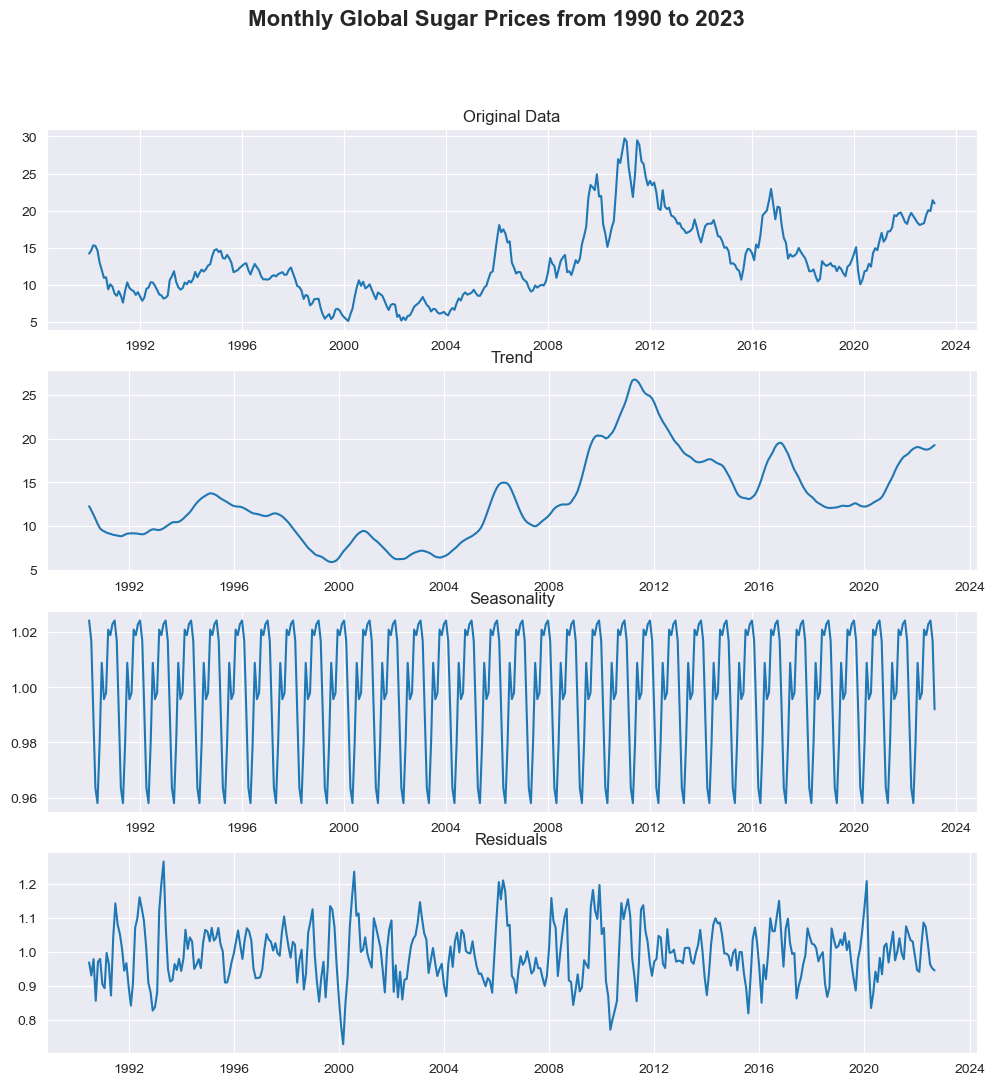

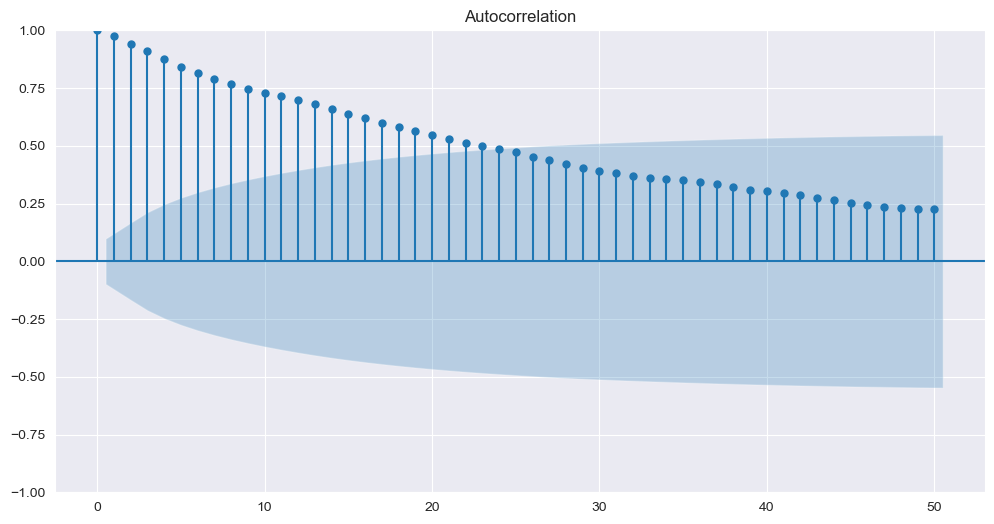

In [27]:
# Perform decomposition analysis

sugar_df.set_index('Date', inplace = True)
sugar_decomposition = sm.tsa.seasonal_decompose(sugar_df['Sugar Price'],
                                          model = 'multiplicative')

# Plot the decomposition results

fig, ax = plt.subplots(nrows = 4, 
                       ncols = 1,
                       figsize = (12, 12))

ax[0].plot(sugar_df['Sugar Price'])
ax[1].plot(sugar_decomposition.trend)
ax[2].plot(sugar_decomposition.seasonal)
ax[3].plot(sugar_decomposition.resid)


ax[0].set_title('Original Data')
ax[1].set_title('Trend')         # the long-term pattern
ax[2].set_title('Seasonality')   # recurring patterns that occur
ax[3].set_title('Residuals')     # unpredictable fluctuations

fig.suptitle("Monthly Global Sugar Prices from 1990 to 2023", fontsize = 16, fontweight = 'bold')

# Perform autocorrelation analysis

fig, ax = plt.subplots(figsize = (12, 6))
sm.graphics.tsa.plot_acf(sugar_df['Sugar Price'],
                         lags = 50,
                         ax = ax)
ax.set_title('Autocorrelation');

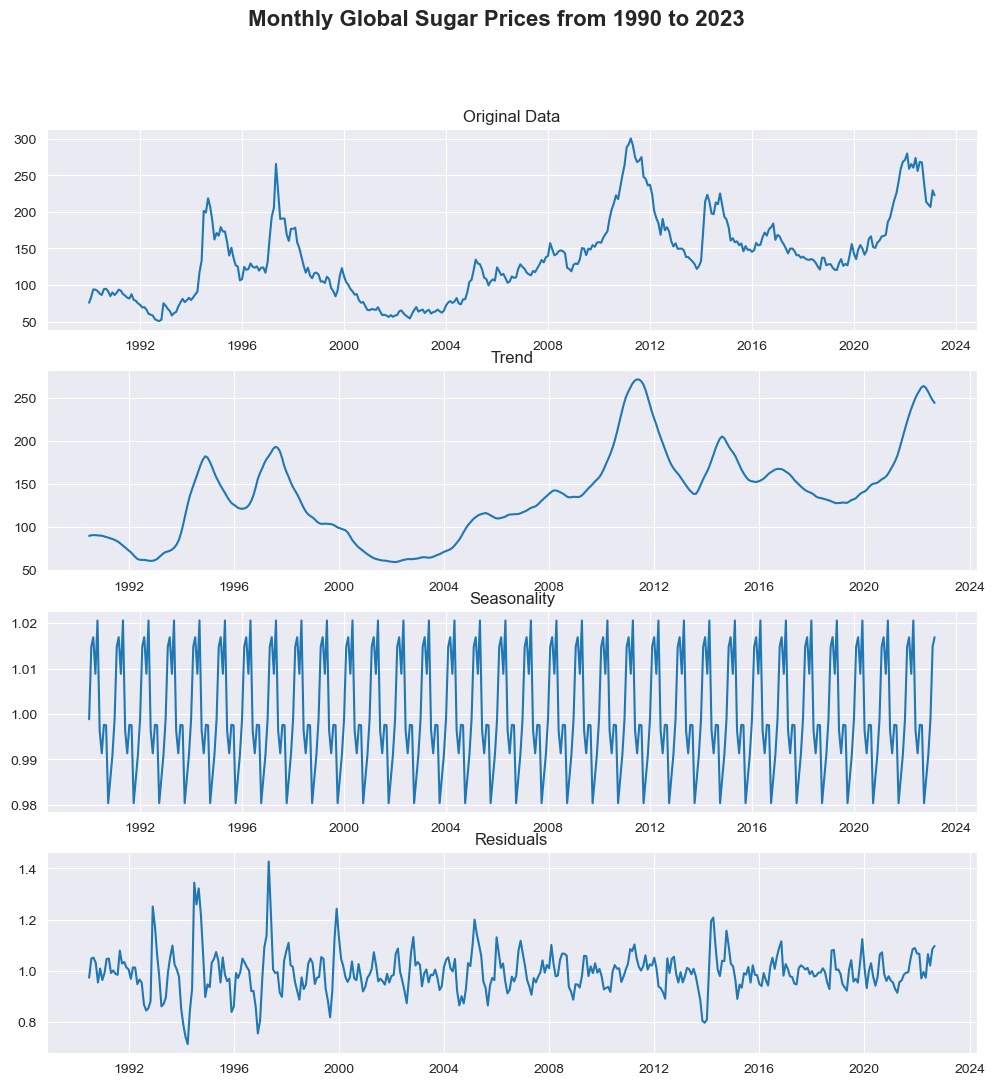

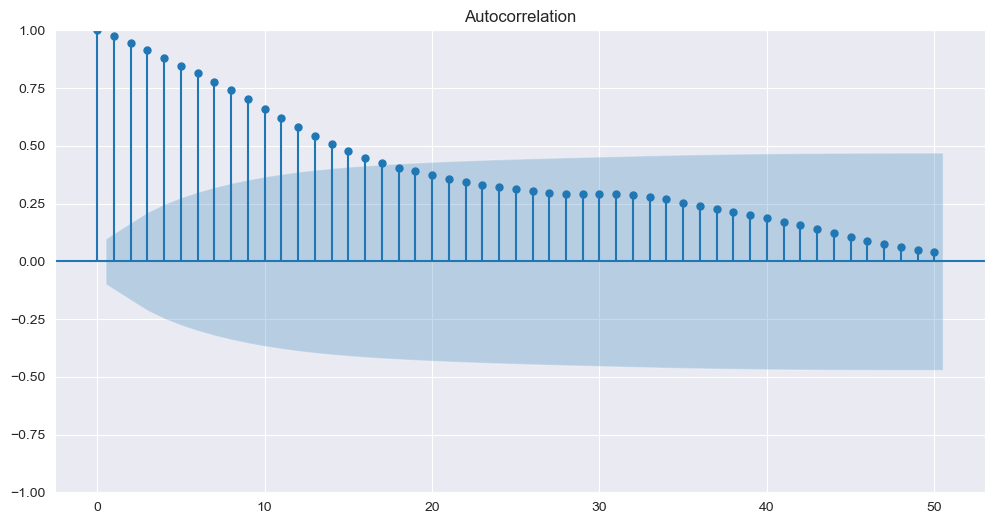

In [28]:
# Perform decomposition analysis

coffee_df.set_index('Date', inplace = True)
coffee_decomposition = sm.tsa.seasonal_decompose(coffee_df['Coffee Price'],
                                          model = 'multiplicative')

# Plot the decomposition results

fig, ax = plt.subplots(nrows = 4, 
                       ncols = 1,
                       figsize = (12, 12))

ax[0].plot(coffee_df['Coffee Price'])
ax[1].plot(coffee_decomposition.trend)
ax[2].plot(coffee_decomposition.seasonal)
ax[3].plot(coffee_decomposition.resid)


ax[0].set_title('Original Data')
ax[1].set_title('Trend')        # the long-term pattern
ax[2].set_title('Seasonality')  # recurring patterns that occur
ax[3].set_title('Residuals')    # unpredictable fluctuations

fig.suptitle("Monthly Global Sugar Prices from 1990 to 2023", fontsize = 16, fontweight = 'bold')

# Perform autocorrelation analysis
fig, ax = plt.subplots(figsize = (12, 6))
sm.graphics.tsa.plot_acf(coffee_df['Coffee Price'],
                         lags = 50,
                         ax = ax)
ax.set_title('Autocorrelation');

# Preprocess the data to prepare it for machine learning

In [29]:
# Remove the difference columns

del coffee_df['Price Difference']
del sugar_df['Price Difference']

In [30]:
# Normalize the data

scaler = MinMaxScaler()

scaled_sugar_data = scaler.fit_transform(sugar_df)
scaled_coffee_data = scaler.fit_transform(coffee_df)

In [31]:
sugar_df['Normalised Sugar Price'] = scaled_sugar_data
coffee_df['Normalised Coffee Price'] = scaled_coffee_data

In [32]:
del sugar_df['Sugar Price']
del coffee_df['Coffee Price']

In [33]:
sugar_df

,Normalised Sugar Price
Date,
2023-03-01,0.643660
2023-02-01,0.661599
2023-01-01,0.602298
2022-12-01,0.607245
2022-11-01,0.580481
...,...
1990-05-01,0.386134
1990-04-01,0.411311
1990-03-01,0.414154


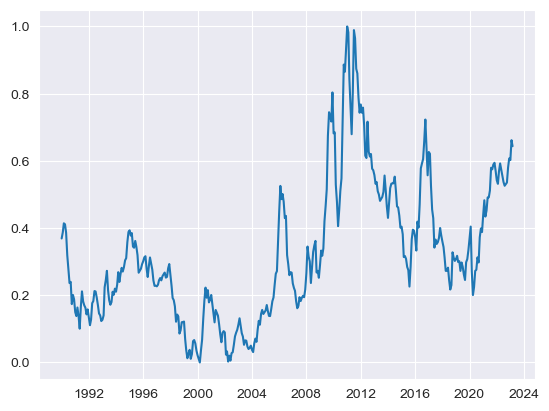

In [34]:
plt.plot(sugar_df);

In [35]:
coffee_df

,Normalised Coffee Price
Date,
2023-03-01,0.688307
2023-02-01,0.715714
2023-01-01,0.624602
2022-12-01,0.639137
2022-11-01,0.652474
...,...
1990-05-01,0.164993
1990-04-01,0.171843
1990-03-01,0.172764


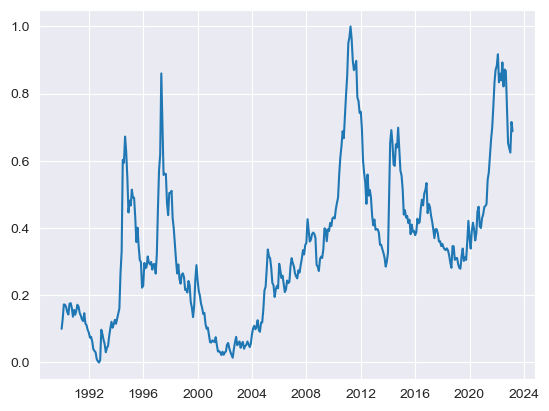

In [36]:
plt.plot(coffee_df);

# Split the data into training and validation sets

In [37]:
# For sugar data
sugar_X = sugar_df.drop('Normalised Sugar Price', axis=1)
sugar_y = sugar_df['Normalised Sugar Price']

sugar_X_train, sugar_X_test, sugar_y_train, sugar_y_test = train_test_split(sugar_X, sugar_y, test_size=0.2)

# For coffee data
coffee_X = coffee_df.drop('Normalised Coffee Price', axis=1)
coffee_y = coffee_df['Normalised Coffee Price']

coffee_X_train, coffee_X_test, coffee_y_train, coffee_y_test = train_test_split(coffee_X, coffee_y, test_size=0.2)

# Training different machine learning models on the training data


## ARIMA

In [38]:
from statsmodels.tsa.arima.model import ARIMA

# Create ARIMA model and fit it to the training data

sugar_arima_model = ARIMA(sugar_y_train, order = (1, 1, 1))
sugar_arima_model_fit = sugar_arima_model.fit()

coffee_arima_model = ARIMA(coffee_y_train, order = (1, 1, 1))
coffee_arima_model_fit = coffee_arima_model.fit()

In [41]:
# Generate predictions for the test data
sugar_arima_predictions = sugar_arima_model_fit.predict(start = len(sugar_y_train), 
                                                  end = len(sugar_y_train) + len(sugar_y_test) - 1,
                                                  typ = 'levels')
coffee_arima_predictions = coffee_arima_model_fit.predict(start = len(coffee_y_train),
                                                    end = len(coffee_y_train) + len(coffee_y_test) - 1,
                                                    typ = 'levels')

In [42]:
# Evaluate the models

sugar_arima_rmse = sqrt(mean_squared_error(sugar_y_test, sugar_arima_predictions))
coffee_arima_rmse = sqrt(mean_squared_error(coffee_y_test, coffee_arima_predictions))

print('Sugar ARIMA RMSE: %.3f' % sugar_arima_rmse)
print('Coffee ARIMA RMSE: %.3f' % coffee_arima_rmse)

Sugar ARIMA RMSE: 0.195
Coffee ARIMA RMSE: 0.221


### Hyperparameter tuning to find  the lowest mean squared error on the training data

In [43]:
from pmdarima.arima import auto_arima

# Define the range of hyperparameters to try
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

# Create a list to store the RMSE scores
sugar_arima_scores = []
coffee_arima_scores = []

# Loop through all possible combinations of hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            # Create ARIMA model with the current hyperparameters
            sugar_model = auto_arima(sugar_y_train,
                                     start_p = p, start_d = d, start_q = q,
                                     max_p = 3, max_d = 2, max_q = 3, 
                                     seasonal = False,
                                     suppress_warnings = True,
                                     error_action = 'ignore', 
                                     stepwise = True)
            
            coffee_model = auto_arima(coffee_y_train,
                                     start_p = p, start_d = d, start_q = q,
                                     max_p = 3, max_d = 2, max_q = 3, 
                                     seasonal = False,
                                     suppress_warnings = True,
                                     error_action = 'ignore', 
                                     stepwise = True)
            
            # Fit the model to the training data
            sugar_model_fit = sugar_model.fit(sugar_y_train)
            coffee_model_fit = coffee_model.fit(coffee_y_train)
            
            # Generate predictions for the test data
            sugar_predictions = sugar_model_fit.predict(n_periods = len(sugar_y_test))
            coffee_predictions = coffee_model_fit.predict(n_periods = len(coffee_y_test))
            
            # Calculate the RMSE for the current model
            sugar_rmse = sqrt(mean_squared_error(sugar_y_test, sugar_predictions))
            coffee_rmse = sqrt(mean_squared_error(coffee_y_test, coffee_predictions))            
            
            # Calculate the MSE
            sugar_mse = mean_squared_error(sugar_y_test, sugar_predictions)
            coffee_mse = mean_squared_error(coffee_y_test, coffee_predictions)
            
            # Calcualte the R2
            sugar_r2 = r2_score(sugar_y_test, sugar_predictions)
            coffee_r2 = r2_score(coffee_y_test, coffee_predictions)
            
            # Store the RMSE score and hyperparameters for the current model
            sugar_arima_scores.append((sugar_rmse, sugar_mse, sugar_r2, p, d, q))
            coffee_arima_scores.append((coffee_rmse, coffee_mse, coffee_r2, p, d, q))

# Sort the list of scores and hyperparameters by RMSE score
sugar_arima_scores.sort()
coffee_arima_scores.sort()

In [44]:
sugar_best_arima_model = sugar_arima_scores[0]
coffee_best_arima_model =coffee_arima_scores[0]

print('Best Sugar ARIMA Model - p:', sugar_best_arima_model[3], 'd:', sugar_best_arima_model[4], 'q:', sugar_best_arima_model[5], 'RMSE:', sugar_best_arima_model[0])
print('Best Coffee ARIMA Model - p:', coffee_best_arima_model[3], 'd:', coffee_best_arima_model[4], 'q:', coffee_best_arima_model[5], 'RMSE:', coffee_best_arima_model[0])


Best Sugar ARIMA Model - p: 0 d: 0 q: 0 RMSE: 0.19653312630233
Best Coffee ARIMA Model - p: 0 d: 0 q: 0 RMSE: 0.22199621135171083


In [45]:
# Fit the ARIMA models with the best hyperparameters
sugar_arima_model = ARIMA(sugar_y_train, order = (0, 0, 0))
sugar_arima_fit = sugar_arima_model.fit()

coffee_arima_model = ARIMA(coffee_y_train, order = (0, 0, 0))
coffee_arima_fit = coffee_arima_model.fit()

# Generate predictions for the test data
sugar_arima_predictions = sugar_arima_fit.predict(start = len(sugar_y_train), 
                                                  end = len(sugar_y_train) + len(sugar_y_test) - 1,
                                                  typ = 'levels')
coffee_arima_predictions = coffee_arima_fit.predict(start = len(coffee_y_train),
                                                    end = len(coffee_y_train) + len(coffee_y_test) - 1,
                                                    typ = 'levels')
sugar_arima_predictions

319    0.330614
320    0.330614
321    0.330614
322    0.330614
323    0.330614
         ...   
394    0.330614
395    0.330614
396    0.330614
397    0.330614
398    0.330614
Name: predicted_mean, Length: 80, dtype: float64

In [46]:
# Store the results of the scores

sugar_results_dict = []
sugar_results = pd.DataFrame.from_dict(sugar_results_dict,
                                    orient='index',  
                                    columns=['RMSE', 'MSE', 'R2'])
sugar_results.loc['ARIMA'] = [sugar_best_arima_model[0], sugar_best_arima_model[1], sugar_best_arima_model[2]]

coffee_results_dict = []
coffee_results = pd.DataFrame.from_dict(coffee_results_dict,
                                    orient='index',  
                                    columns=['RMSE', 'MSE', 'R2'])
coffee_results.loc['ARIMA'] = [coffee_best_arima_model[0], coffee_best_arima_model[1], coffee_best_arima_model[2]]

In [47]:
sugar_results

,RMSE,MSE,R2
ARIMA,0.196533,0.038625,-0.025669


In [48]:
coffee_results

,RMSE,MSE,R2
ARIMA,0.221996,0.049282,-0.009879


# SARIMA

In [49]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Create SARIMA model and fit it to the training data

sugar_sarima_model = SARIMAX(sugar_y_train,
                             order = (1, 1, 1),
                             seasonal_order = (1, 0 , 0, 12))

sugar_sarima_model_fit = sugar_sarima_model.fit(disp=False)


coffee_sarima_model = SARIMAX(coffee_y_train, 
                             order = (1, 1, 1),
                             seasonal_order = (1, 0, 0, 12))

coffee_sarima_model_fit = coffee_sarima_model.fit(disp=False)

In [50]:
# Generate predictions for the test data

sugar_sarima_predictions = sugar_sarima_model_fit.predict(start = len(sugar_y_train), 
                                                        end = len(sugar_y_train) + len(sugar_y_test) - 1,
                                                        typ = 'levels')
coffee_sarima_predictions = coffee_sarima_model_fit.predict(start = len(coffee_y_train),
                                                         end = len(sugar_y_train) + len(sugar_y_test) - 1,
                                                         typ = 'levels')

In [51]:
# Evaluate the models

sugar_sarima_rmse = sqrt(mean_squared_error(sugar_y_test, sugar_sarima_predictions))
coffee_sarima_rmse = sqrt(mean_squared_error(coffee_y_test, coffee_sarima_predictions))

print('Sugar SARIMA RMSE: %.3f' % sugar_sarima_rmse)
print('Coffee SARIMA RMSE: %.3f' % coffee_sarima_rmse)

Sugar SARIMA RMSE: 0.195
Coffee SARIMA RMSE: 0.222


In [66]:
from itertools import product

# Define the range of hyperparameters to search over
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
P = range(0, 3)
D = range(0, 2)
Q = range(0, 3)
s = 12

# Create a list of all possible combinations of hyperparameters
params = product(p, d, q, P, D, Q)

# Define a function to evaluate the RMSE of a given combination of hyperparameters
def evaluate_sarima_model(y_train, y_testa, order, seasonal_order):
    try:
        model = SARIMAX(y_train, 
                        order = order, 
                        seasonal_order = seasonal_order)
        model_fit = model.fit(disp = False)
        predictions = model_fit.predict(start = len(y_train), 
                                        end = len(y_train) + len(y_test)-1,
                                        typ='levels')
        rmse = sqrt(mean_squared_error(y_testa, predictions))
    except:
        rmse = float('inf')
    return rmse

# Perform grid search over all possible combinations of hyperparameters
sugar_best_rmse = float('inf')
coffee_best_rmse = float('inf')

sugar_best_params = None
coffee_best_params = None
for param in params:
    order = (param[0], param[1], param[2])
    seasonal_order = (param[3], param[4], param[5], s)
    try:
        sugar_rmse = evaluate_sarima_model(sugar_y_train,
                                           sugar_y_test,
                                           order,
                                           seasonal_order)
        if sugar_rmse < sugar_best_rmse:
            sugar_best_rmse = sugar_rmse
            sugar_best_params = (order, seasonal_order)
            
        coffee_rmse = evaluate_sarima_model(coffee_y_train,
                                            coffee_y_test,
                                            order,
                                            seasonal_order)
        if coffee_rmse < coffee_best_rmse:
            coffee_best_rmse = coffee_rmse
            coffee_best_params = (order, seasonal_order)
    except:
        continue

if sugar_best_params is not None:
    sugar_sarima_model = SARIMAX(sugar_y_train,
                                 order = sugar_best_params[0],
                                 seasonal_order = sugar_best_params[1])

    sugar_sarima_model_fit = sugar_sarima_model.fit(disp=False)
    sugar_sarima_predictions = sugar_sarima_model_fit.predict(start = len(sugar_y_train),
                                                              end = len(sugar_y_train) + len(sugar_y_test) - 1, 
                                                              typ='levels')
else:
    print('No valid hyperparameters found for SARIMA model on sugar data')
if coffee_best_params is not None:
    coffee_sarima_model = SARIMAX(coffee_y_train,
                                  order = coffee_best_params[0],
                                  seasonal_order = coffee_best_params[1])

    coffee_sarima_model_fit = coffee_sarima_model.fit(disp=False)
    coffee_sarima_predictions = coffee_sarima_model_fit.predict(start = len(coffee_y_train),
                                                              end = len(coffee_y_train) + len(coffee_y_test) - 1, 
                                                              typ='levels')
else:
    print('No valid hyperparameters found for SARIMA model on coffee data')

No valid hyperparameters found for SARIMA model on sugar data
No valid hyperparameters found for SARIMA model on coffee data


In [54]:
# Fit the model with the best hyperparameters and generate predictions for the test data

sugar_sarima_model = SARIMAX(sugar_y_train,
                             order = (1, 1, 1),
                             seasonal_order = (1, 0 , 0, 12))

sugar_sarima_model_fit = sugar_sarima_model.fit(disp=False)
sugar_sarima_predictions = sugar_sarima_model_fit.predict(start = len(sugar_y_train),
                                                          end = len(sugar_y_train) + len(sugar_y_test) - 1, 
                                                          typ='levels')

coffee_sarima_model = SARIMAX(coffee_y_train,
                              order = (1, 1, 1),
                              seasonal_order = (1, 0 , 0, 12))

coffee_sarima_model_fit = coffee_sarima_model.fit(disp = False)
coffee_sarima_predictions = coffee_sarima_model_fit.predict(start = len(coffee_y_train),
                                                          end = len(coffee_y_train) + len(coffee_y_test) - 1, 
                                                          typ='levels')

In [56]:
# Evaluate the performance of the model
sugar_sarima_rmse = sqrt(mean_squared_error(sugar_y_test, sugar_sarima_predictions))
coffee_sarima_rmse = sqrt(mean_squared_error(coffee_y_test, coffee_sarima_predictions))

sugar_sarima_mse = mean_squared_error(sugar_y_test, sugar_sarima_predictions)
sugar_sarima_r2 = r2_score(sugar_y_test, sugar_sarima_predictions)

sugar_results.loc['SARIMA'] = [sugar_sarima_rmse, sugar_sarima_mse, sugar_sarima_r2]

coffee_sarima_mse = mean_squared_error(coffee_y_test, coffee_sarima_predictions)
coffee_sarima_r2 = r2_score(coffee_y_test, coffee_sarima_predictions)

coffee_results.loc['SARIMA'] = [coffee_sarima_rmse, coffee_sarima_mse, coffee_sarima_r2]

In [57]:
sugar_results

,RMSE,MSE,R2
ARIMA,0.196533,0.038625,-0.025669
SARIMA,0.194805,0.037949,-0.007708


In [58]:
coffee_results

,RMSE,MSE,R2
ARIMA,0.221996,0.049282,-0.009879
SARIMA,0.222077,0.049318,-0.010617


In [59]:
sugar_results = sugar_results.sort_values(by = 'RMSE', ascending = False).reset_index()
coffee_results = coffee_results.sort_values(by = 'RMSE', ascending = False).reset_index()

In [60]:
sugar_results

,index,RMSE,MSE,R2
0,ARIMA,0.196533,0.038625,-0.025669
1,SARIMA,0.194805,0.037949,-0.007708


In [61]:
coffee_results

,index,RMSE,MSE,R2
0,SARIMA,0.222077,0.049318,-0.010617
1,ARIMA,0.221996,0.049282,-0.009879


# Forecasting

In [63]:
#predicting the projections for the next 3 months

sugar_forecast = sugar_sarima_model_fit.forecast(steps=3)
coffee_forecast = coffee_sarima_model_fit.forecast(steps=3)

In [64]:
sugar_forecast.tail(3)

319    0.335556
320    0.342289
321    0.333238
Name: predicted_mean, dtype: float64

In [65]:
coffee_forecast.tail(3)

319    0.362074
320    0.362315
321    0.324935
Name: predicted_mean, dtype: float64